<p>
<font size=5 color="#5A5A5A" face = "Lano"><center><b><font size=5 color="#FCAC45" face = "Lano">People Analytics:</font></b> MIST</center></font>
</p>
<p>
<center><font size=3 color="#5A5A5A" face = "Lano"><em>
Python 3<br>
OCTO Technology - Clément Tailleur - People Analytics : <u>Data Visualization</u>
</em></font></center>
</p>
<br>

<font size=4 color="#FCAC45" face = "Lano"><B><u>Sommaire</u></B>
</font><br><br>
<font size=3.2 color="#5A5A5A" face = "Lano">
  <a href='#XII'><font color = "#5A5A5A"><b>XII</b> - Graphical representation</font></a><br>
  &nbsp;&nbsp;&nbsp;<b>A</b> - Group and filter interactions: example with 'technical' topic<br>
  &nbsp;&nbsp;&nbsp;<b>B</b> - Visualizations et automations: example with 'technical'topic<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>a.</b>  Display the n higher interactions (n=500)<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>b.</b>  Display the n higher interactions by sender (n=5)<br>
  </font>
<br>

<font size=5 color="#5A5A5A" face = "Lano">
  <a id='XII'></a>
  <b>XII</b> - Graphical representation<br>
  <font size=4>
  &nbsp;&nbsp;&nbsp;<b>A</b> - Group and filter interactions: example with 'technical' topic<br>
  </font>
</font>

In [38]:
import pandas as pd

# We recover data classified by topics
df_visualization = pd.read_csv("../data/data_processed.csv")[["Sender", "Addressee", "Year", "Subject_Stem"]]
len(df_visualization)

849098

In [39]:
df_visualization.head()

,Sender,Addressee,Year,Subject_Stem
0,mvigogne,digla,2017,venez bouger corp
1,mmogollon,afaure,2017,invitation baf sanofi alain faure
2,mmogollon,mlagacherie,2017,invitation baf sanofi alain faure
3,afaure,mmogollon,2017,diagramme
4,mmogollon,afaure,2017,diagramme


In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

# Use GridSearch in order to find best parameters
parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9,10], 
              'gamma': [0.01,0.02,0.03,0.04,0.05]}
#clf_SMV_ALL = svm.SVC()
#grid = GridSearchCV(clf_SMV_ALL, parameters)
#grid = grid.fit(X_learning2_counts, Ytarget2)
#joblib.dump(grid.best_params_, '../models/SVM/best_parameters.pkl')
best_params = joblib.load('../models/SVM/best_parameters.pkl')

c = best_params["C"]
kernel = best_params["kernel"]
gamma = best_params["gamma"]
print("C:", c, "\nKernel:", kernel, "\nGamma:", gamma)

C: 4 
Kernel: rbf 
Gamma: 0.04


In [41]:
from sklearn import svm

clf_SVM_BEST = joblib.load("../models/SVM/best_classifier.pkl")
VEC_learning = joblib.load("../models/SVM/vectorizer.pkl")


subjects_cleaned = df_visualization['Subject_Stem'].tolist()
subjects_cleaned_counts = VEC_learning.transform(subjects_cleaned)
predicted_topics = clf_SVM_BEST.predict(subjects_cleaned_counts)

In [46]:
df_visualization['Prediction'] = predicted_topics
df_visualization.head(50)[23:28]

,Sender,Addressee,Year,Subject_Stem,Prediction
23,cfiocre,xjulien,2017,people newsletter tribu webf derniere,2
24,mhamon,xjulien,2017,people newsletter tribu webf derniere,2
25,sboulkour,meljai,2017,tech file upload protection,1
26,bfiorentino,sboulkour,2017,tech file upload protection,1
27,bfiorentino,meljai,2017,tech file upload protection,1


In [47]:
#On commence par réduire notre dataframe aux objets appartenant au dictionnaire 'technical' en 2015
df_technical_2015 = df_visualization[(df_visualization.Prediction == 1) & (df_visualization.Year == "2015")].copy()
print("Nombre de d'objets appartenant au dictionnaire Technical:", len(df_technical_2015))

Nombre de d'objets appartenant au dictionnaire Technical: 56360


In [48]:
import numpy as np

def get_interlocutors(x, y):
    z = [x, y]
    z.sort()
    z = z[0] + "|" + z[1]
    return z

# On va créer une colonne interlocuteurs qui va simplement afficher les deux interlocuteurs
# dans l'ordre alphabétique et séparés par un '|' -> On vise un groupby efficace. 
#df_request['Interlocutors'] = df_request.apply(get_interlocutors, axis=1)
df_technical_2015['Interlocutors'] = np.vectorize(get_interlocutors)(df_technical_2015['Sender'], df_technical_2015['Addressee'])

# Concatène ce dataframe en les groupant par Destinataire et par Expediteur
# de façon à avoir le nombre d'intéractions dont les objets est catégorisé 'request'.
s_tech2015_concat = df_technical_2015.groupby(['Interlocutors']).size()
df_tech2015_concat = s_tech2015_concat.reset_index()
df_tech2015_concat.columns = ['Interlocutors', 'Interactions']

#Afficher les 7 intéractions les plus fortes
df_tech2015_concat.sort_values(by = ['Interactions'], ascending=[False]).head(7)

,Interlocutors,Interactions
5567,sfagnent|sperin,1404
5193,ngrellier|sfagnent,332
5194,ngrellier|sperin,290
2066,cabdelnour|sfagnent,278
3495,fjaby|fpetitit,272
2071,cabdelnour|sperin,244
1967,btoch|mbojoly,208


In [49]:
# On va désormais recréer notre dataframe sans désormais tenir compte de qui est l'expéditeur
# ou le destinataire. 
s = df_tech2015_concat['Interlocutors'].apply(lambda x: x.split('|'))
df_tech2015_concat['Interlocutor_1'] = s.apply(lambda x: x[0])
df_tech2015_concat['Interlocutor_2'] = s.apply(lambda x: x[1])
len(df_tech2015_concat)

5709

In [50]:
#On prend le Top500 des intéractions Request
df_tech2015_concat = df_tech2015_concat.sort_values(by = ['Interactions'], ascending=[False]).head(500)

#Puis on réindex notre dataframe
df_tech2015_concat = df_tech2015_concat.reset_index()
df_tech2015_concat = df_tech2015_concat[['Interlocutor_1', 'Interlocutor_2', 'Interactions']]

<font size=4 color="#5A5A5A" face = "Lano">
  &nbsp;&nbsp;&nbsp;<b>B</b> - Visualisations et automatisations: exemple avec le dictionnaire 'technical'<br>
  <font size=3>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>a</b>. Afficher les n plus fortes intéractions (n=500)
  </font>
</font>

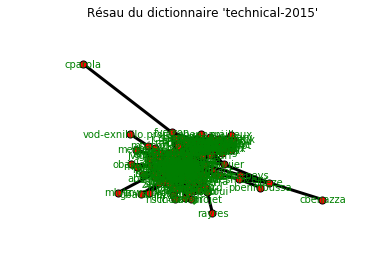

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

# Création d'un graphique sans direction
G_Technical2015_top500 = nx.Graph()

# Ici on va créer les liens entre les expéditeurs et les destinataires en donnant à l'argument
# 'weight' de la fonction add_edge la valeur du nombre d'intéractions.
for i in range(len(df_tech2015_concat)):
    G_Technical2015_top500.add_edge(df_tech2015_concat["Interlocutor_1"][i],
                                    df_tech2015_concat["Interlocutor_2"][i],
                                    weight = df_tech2015_concat["Interactions"][i])

# Générateur automatique de la position des noeuds dans le graphique.
pos = nx.spring_layout(G_Technical2015_top500) 

# Création des noeuds 
nx.draw_networkx_nodes(G_Technical2015_top500, pos, node_size=50)

# Création des liens (branches)
nx.draw_networkx_edges(G_Technical2015_top500, pos, width=3, edge_color='black')

# Affichage des labels des noeuds
nx.draw_networkx_labels(G_Technical2015_top500, pos, font_size=10, font_family='sans-serif', font_color="green")

# Affichage et sauvegarde du graphique.
plt.axis('off')
plt.title("Résau du dictionnaire 'technical-2015'")
plt.savefig("description_nb/networkx_generated/Top500_technical_2015")
plt.show() 

In [52]:
# C'est pas très beau comme graphique :/
# Donc on va passer sur Gephi en sauvegardant notre réseau!
nx.write_gexf(G_Technical2015_top500, "description_nb/networkx_generated/Top500_technical_2015.gexf")

#Hop hop hop, avant ça, un peu d'automatisation !

In [53]:
from pypletics import get_my_network

help(get_my_network)

Help on function get_my_network in module pypletics.network:

get_my_network(df_target, sender_column, addressee_column, graph_name, generate_png=False, generate_gexf=False, top_n=None)
    'get_my_network' function from pyple package take as parameters a dataframe with 2 columns representing an exchange like sender-addressee. 
    The second parameter will be the name of the first column, the third parameter will be the name of the second column. 
    Using the fourth parameter you will give a name to your network as a file and as a plot graphic too.
    You can choose with the 5th and the 6th parameters to save the result as .png ou .gexf.
    If you don't specified these arguments, they won't be generated by default.
    The last parameter is optional and allow us to choose the number of the best interactions you want to work with.
    Without the 'top_n' argument, the function will work with the all interactions of your dataframe.
    Once this function will be executed, an array w

In [54]:
df_tech2016_concat = df_visualization[(df_visualization.Prediction == 1)
                                      & (df_visualization.Year == "2016")
                                      & (df_visualization.Sender != "sperin")
                                      & (df_visualization.Addressee != "sperin")].copy()
print("Taille de df_tech2016_concat", len(df_tech2016_concat))
df_tech2016_concat[["Sender", "Addressee"]].head()

Taille de df_tech2016_concat 40788


,Sender,Addressee
5001,tcantet,fxbonnet
5002,ncarlo,tcantet
5003,ncarlo,fxbonnet
5004,afaure,ncarlo
5005,afaure,tcantet


In [55]:
technical_network = get_my_network(df_tech2016_concat, df_tech2016_concat.Sender, df_tech2016_concat.Addressee, 
                                   "description_nb/networkx_generated/Top500_technical_2016", 
                                   generate_gexf = True, top_n = 500)

technical_network[0].head()

,Interlocutor_1,Interlocutor_2,Interactions
0,btoch,fjaby,164
1,btoch,mbojoly,150
2,fjaby,ldutheil,148
3,fjaby,tgery,142
4,agrodrigues,mbojoly,128


<class 'networkx.classes.graph.Graph'> 



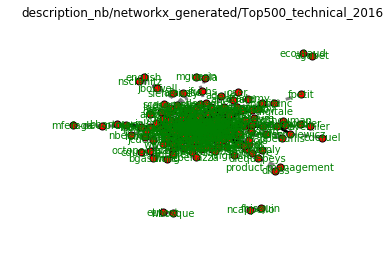

In [56]:
print(type(technical_network[2]), '\n')
technical_network[1].show() 

In [64]:
from IPython.display import Image

def show_results(graph):
    path = "description_nb/animations/" + graph 
    return Image(url = path)

print("Et voilà le genre de résultats qu'on peut obtenir avec Gephi ! -> technical-2016")
show_results("Top500_technical_2016_8C.pdf")

Et voilà le genre de résultats qu'on peut obtenir avec Gephi ! -> technical-2016


<font size=3 color="#5A5A5A" face = "Lano">
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>b</b>.  Afficher les n plus fortes intéractions par expéditeur (n=5)<br>
</font>

In [58]:
#5 intéractions les plus fortes par "Sender"
# Test avec 'technical' 2016
df_technical_2016 = df_visualization[(df_visualization.Prediction == 1) & (df_visualization.Year == "2016")].copy() 

df_technical_2016_top5_bysender = df_technical_2016.groupby(["Sender"]).head(5)

df_technical_2016_bysenderaddressee = df_technical_2016.groupby(["Sender", "Addressee"]).size().reset_index()
df_technical_2016_bysenderaddressee = df_technical_2016_bysenderaddressee[["Sender", "Addressee", 0]]
df_technical_2016_bysenderaddressee.columns = ["Sender", "Addressee", "Interactions"]

df_technical2016_top5_bysender = pd.merge(df_technical_2016_top5_bysender, df_technical_2016_bysenderaddressee, on=['Sender', 'Addressee'], how='left')

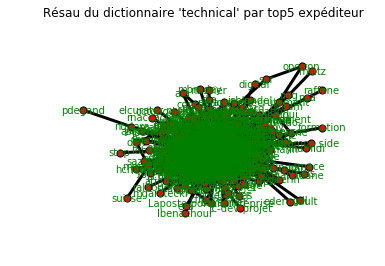

In [59]:
# Création d'un graphique sans direction
G_Technical2016_bytop5sender = nx.Graph()

# Ici on va créer les liens entre les expéditeurs et les destinataires en donnant à l'argument
# 'weight' de la fonction add_edge la valeur du nombre d'intéractions.
for i in range(len(df_technical2016_top5_bysender)):
    G_Technical2016_bytop5sender.add_edge(df_technical2016_top5_bysender["Sender"][i],
                                          df_technical2016_top5_bysender["Addressee"][i],
                                          weight = df_technical2016_top5_bysender["Interactions"][i])

# Générateur automatique de la position des noeuds dans le graphique.
pos = nx.spring_layout(G_Technical2016_bytop5sender) 

# Création des noeuds 
nx.draw_networkx_nodes(G_Technical2016_bytop5sender, pos, node_size=50)

# Création des liens (branches)
nx.draw_networkx_edges(G_Technical2016_bytop5sender, pos, width=3, edge_color='black')

# Affichage des labels des noeuds
nx.draw_networkx_labels(G_Technical2016_bytop5sender, pos, font_size=10, font_family='sans-serif', font_color="green")

# Affichage et sauvegarde du graphique.
plt.axis('off')
plt.title("Résau du dictionnaire 'technical' par top5 expéditeur")
plt.savefig("description_nb/networkx_generated/ByTop5_technical_2016")
plt.show() 

In [60]:
nx.write_gexf(G_Technical2016_bytop5sender, "description_nb/networkx_generated/ByTop5_technical_2016.gexf")

show_results("ByTop5_technical_2016_13C.pdf")

In [17]:
# Aller un petit exemple !!
!open description_nb/animations/Pres_Gephi.mov

![title](description_nb/animations/end.jpeg)
<p>
<center><font size=3 color="#5A5A5A" face = "Lano"><em>
OCTO Technology - CLT
</em></font></center>
</p>